## Environment setup
Modify the following cell to set the working directory to your project root folder. 
Remember to properly use double backslash to avoid python interpreting the path separator as an escape character. 

In [33]:
import os 

# SET HERE YOUR ROOTPATH
rootpath = 'C:\\Users\\chiar\\OneDrive\\Desktop\\XrAI'

# Set the working directory
os.chdir(rootpath) 

Run the following cell to install all required modules.

In [ ]:
%pip install -r requirements.txt

## Unzip

In [36]:
import shutil

# RUN THIS CELL ONLY ONCE TO EXTRACT THE TRAINING SET FROM THE ZIP FILE
filepath = "train_set.zip"
shutil.unpack_archive(filepath, "original_dataset")

## Important remarks

The very first thing to do when developing data-driven models is to save a portion of the original dataset as final benchmark data, namely a dataset that do not contributes to model development to be used to evaluate the model performances on unseen data. 

When dealing with supervised tasks it is good practice to use a stratified split over classes to ensure that each split contains a representative sample of the data.

Additionally, when working with medical data, if multiple samples related to the same patient are provided, it is important to ensure that those samples are kept together troughout the split for two main reasons:
1. to allow the model to learn from the relationships between them;
2. to avoid evaluating the model on data that were partially already comprehended in the training split.

## Dataset partitioning  

Available data will be divided in 3 parts:
- Training data, to be used for model training,
- Validation data, to be used as benchmark data for decision making and hyperparameter tuning, 
- Test set, to be used for model final evaluation.

The split will be performed in 2 steps: 
1. Virtual split, during which the dataset partitioning will be defined over image filenames, taking into account the constraints regarding the patient and the stratification over classes,
2. File sorting, during which the files will be moved to the corresponding folders according to the virtual split.

### Virtual split

In [37]:
import csv
import pandas as pd

# Load the data from the CSV file into a DataFrame
csv_df = pd.read_csv('original_dataset\\train\\labels_train.csv')
csv_df = csv_df.assign(Patient_ID = csv_df['file'].map(lambda x:x[1:6]))
print(csv_df.shape)
csv_df.head(20)

(15470, 3)


,file,label,Patient_ID
0,P00001_1.png,N,00001
1,P00001_2.png,N,00001
2,P00002_1.png,N,00002
3,P00003_1.png,N,00003
4,P00004_1.jpeg,N,00004
5,P00005_1.png,T,00005
6,P00005_2.png,T,00005
7,P00006_1.png,N,00006
8,P00006_2.png,N,00006
9,P00007_1.png,N,00007


In [38]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

# Create the GroupShuffleSplit object
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2)
X = csv_df['file']
y = csv_df['label']
patients = csv_df['Patient_ID']

# Split the training and validation data into groups, with each group containing the images for a single patient
for train_index, test_index in gss.split(X, y, groups=patients):
    # Get the training and validation data for this split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    patients_train, patients_test = patients[train_index], patients[test_index]

In [39]:
gss2 = GroupShuffleSplit(n_splits=1, train_size=0.9, test_size=0.1)
X = X_train.reset_index(drop=True)
y = y_train.reset_index(drop=True)
patients = patients_train.reset_index(drop=True)

# Split the training and validation data into groups, with each group containing the images for a single patient
for training_index, val_index in gss2.split(X, y, groups=patients):
    # Get the training and validation data for this split
    X_training, X_val = X[training_index], X[val_index]
    y_training, y_val = y[training_index], y[val_index]
    patients_training, patients_val = patients[training_index], patients[val_index]

In [40]:
def inspect_set(X, y, pat, label):
    d = {'X': X.reset_index(drop=True), 'y': y.reset_index(drop=True), 'patients': pat.reset_index(drop=True)}
    df = pd.DataFrame(data=d)
    print(label, " : ", df.shape)
    print(df)
    return df

In [41]:
df_train = inspect_set(X_training, y_training, patients_training, "Training")

Training  :  (11129, 3)
                   X  y patients
0       P00001_1.png  N    00001
1       P00001_2.png  N    00001
2       P00002_1.png  N    00002
3       P00003_1.png  N    00003
4      P00004_1.jpeg  N    00004
...              ... ..      ...
11124   P16110_1.png  T    16110
11125   P16111_1.png  N    16111
11126  P16112_1.jpeg  N    16112
11127   P16113_1.png  N    16113
11128   P16114_1.png  T    16114

[11129 rows x 3 columns]


In [42]:
df_val = inspect_set(X_val, y_val, patients_val, "Validation")

Validation  :  (1246, 3)
                  X  y patients
0      P00008_1.png  N    00008
1      P00027_1.png  N    00027
2      P00027_2.png  N    00027
3     P00043_1.jpeg  P    00043
4     P00050_1.jpeg  N    00050
...             ... ..      ...
1241  P16061_1.jpeg  N    16061
1242  P16073_1.jpeg  P    16073
1243  P16088_1.jpeg  N    16088
1244   P16105_1.png  N    16105
1245  P16109_1.jpeg  P    16109

[1246 rows x 3 columns]


In [43]:
df_test = inspect_set(X_test, y_test, patients_test, "Test")

Test  :  (3095, 3)
                  X  y patients
0      P00007_1.png  N    00007
1      P00007_2.png  N    00007
2     P00011_1.jpeg  P    00011
3     P00011_2.jpeg  P    00011
4     P00024_1.jpeg  P    00024
...             ... ..      ...
3090  P16092_1.jpeg  P    16092
3091  P16096_1.jpeg  P    16096
3092   P16103_1.png  N    16103
3093  P16107_1.jpeg  P    16107
3094   P16115_1.png  N    16115

[3095 rows x 3 columns]


In [44]:
def check_pat_group(df1, df2, name1, name2):
  print(f"Check patient division: {name1} vs {name2}")
  pat_list1 = df1['patients']
  pat_list2 = df2['patients']
  for name in pat_list1: 
    if name in pat_list2: print(name)

In [45]:
check_pat_group(df_train, df_test, "TRAIN", "TEST")
check_pat_group(df_test, df_train, "TEST", "TRAIN")
check_pat_group(df_train, df_val, "TRAIN", "VAL")
check_pat_group(df_val, df_train, "VAL", "TRAIN")
check_pat_group(df_test, df_val, "TEST", "VAL")
check_pat_group(df_val, df_test, "VAL", "TEST")

Check patient division: TRAIN vs TEST
Check patient division: TEST vs TRAIN
Check patient division: TRAIN vs VAL
Check patient division: VAL vs TRAIN
Check patient division: TEST vs VAL
Check patient division: VAL vs TEST


In [46]:
def target_count(y, label):
  l1 = y[y=='N'].count()
  l2 = y[y=='T'].count()
  l3 = y[y=='P'].count()
  tot = y.count()
  print(label,": ", l1,"(", round(l1/tot, 2) ,")", " vs ", l2,"(", round(l2/tot, 2) ,")",  " vs ", l3,"(", round(l3/tot, 2) ,")", "(Tot:", tot, ")")

In [47]:
print("NUMBER OF NORMAL VS TUBERCOLOSIS VS PNEUMONIA")
target_count(csv_df['label'], "Original dataset")
target_count(df_train['y'], "Training")
target_count(df_val['y'], "Validation")
target_count(df_test['y'], "Test")

NUMBER OF NORMAL VS TUBERCOLOSIS VS PNEUMONIA
Original dataset :  9354 ( 0.6 )  vs  1866 ( 0.12 )  vs  4250 ( 0.27 ) (Tot: 15470 )
Training :  6790 ( 0.61 )  vs  1341 ( 0.12 )  vs  2998 ( 0.27 ) (Tot: 11129 )
Validation :  746 ( 0.6 )  vs  149 ( 0.12 )  vs  351 ( 0.28 ) (Tot: 1246 )
Test :  1818 ( 0.59 )  vs  376 ( 0.12 )  vs  901 ( 0.29 ) (Tot: 3095 )


### File sorting

In [49]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created: ", path)
    else: print("Directory already exists: ", path)


In [48]:
source_dir = 'original_dataset/train'
dest_dir = 'splitted_dataset'
N='normal'
T='tubercolosis'
P='pneumonia'

In [53]:
make_dir(dest_dir)
for x in ['train', 'val', 'test']:
    for y in [N, T, P]:
        make_dir(os.path.join(dest_dir, x, y))

Directory already exists:  splitted_dataset
Directory created:  splitted_dataset\train\normal
Directory created:  splitted_dataset\train\tubercolosis
Directory created:  splitted_dataset\train\pneumonia
Directory created:  splitted_dataset\val\normal
Directory created:  splitted_dataset\val\tubercolosis
Directory created:  splitted_dataset\val\pneumonia
Directory created:  splitted_dataset\test\normal
Directory created:  splitted_dataset\test\tubercolosis
Directory created:  splitted_dataset\test\pneumonia


In [54]:
print(os.listdir('splitted_dataset'))
print(os.listdir('splitted_dataset/train'))
print(len(os.listdir('splitted_dataset/train/normal'))+len(os.listdir('splitted_dataset/train/tubercolosis'))+len(os.listdir('splitted_dataset/train/pneumonia')))
print(os.listdir('splitted_dataset/val'))
print(len(os.listdir('splitted_dataset/val/normal'))+len(os.listdir('splitted_dataset/val/tubercolosis'))+len(os.listdir('splitted_dataset/val/pneumonia')))
print(os.listdir('splitted_dataset/test'))
print(len(os.listdir('splitted_dataset/test/normal'))+len(os.listdir('splitted_dataset/test/tubercolosis'))+len(os.listdir('splitted_dataset/test/pneumonia')))

['test', 'train', 'val']
['normal', 'pneumonia', 'tubercolosis']
0
['normal', 'pneumonia', 'tubercolosis']
0
['normal', 'pneumonia', 'tubercolosis']
0


In [51]:
import os
l = os.listdir(source_dir)
if "labels_train.csv" in l : l.remove("labels_train.csv")
print(len(l))
print(l)

15470
['P00001_1.png', 'P00001_2.png', 'P00002_1.png', 'P00003_1.png', 'P00004_1.jpeg', 'P00005_1.png', 'P00005_2.png', 'P00006_1.png', 'P00006_2.png', 'P00007_1.png', 'P00007_2.png', 'P00008_1.png', 'P00010_1.png', 'P00011_1.jpeg', 'P00011_2.jpeg', 'P00012_1.jpeg', 'P00013_1.jpeg', 'P00014_1.png', 'P00014_2.png', 'P00016_1.png', 'P00020_1.jpeg', 'P00020_2.jpeg', 'P00021_1.png', 'P00022_1.jpeg', 'P00022_2.jpeg', 'P00023_1.png', 'P00023_2.png', 'P00024_1.jpeg', 'P00024_2.jpeg', 'P00026_1.png', 'P00026_2.png', 'P00027_1.png', 'P00027_2.png', 'P00029_1.png', 'P00030_1.png', 'P00030_2.png', 'P00031_1.png', 'P00034_1.png', 'P00034_2.png', 'P00035_1.png', 'P00035_2.png', 'P00036_1.jpeg', 'P00037_1.png', 'P00037_2.png', 'P00038_1.png', 'P00039_1.png', 'P00040_1.jpeg', 'P00042_1.jpeg', 'P00043_1.jpeg', 'P00044_1.png', 'P00046_1.png', 'P00046_2.png', 'P00048_1.png', 'P00049_1.png', 'P00049_2.png', 'P00050_1.jpeg', 'P00050_2.jpeg', 'P00051_1.png', 'P00053_1.png', 'P00053_2.png', 'P00054_1.jpeg',

In [55]:
def create_set_folder(df, dir_label, source_dir, dest_dir):

  dest = os.path.join(dest_dir, dir_label)

  print()
  print("########## Creating Set Folder ##########")
  print("From ", source_dir, "to ", dest)

  count = 0
  for index, row in df.iterrows():
    file_name = row['X']
    if row['y']=='T': label = T 
    elif row['y']=='P': label = P
    elif row['y']=='N': label = N    
    else: 
      print('ERROR: new label found for file', file_name, '-' , row['y'])
      label = ''
      
    src = os.path.join(source_dir, file_name)
    dst = os.path.join(os.path.join(dest, label), file_name)
    # print("from ", src, " to ", dst)
    os.replace(src,dst)
    count= count+1

  print(count," items moved")


In [56]:
create_set_folder(df_train, "train", source_dir, dest_dir)


########## Creating Set Folder ##########
From  original_dataset/train to  splitted_dataset\train
11129  items moved


In [57]:
create_set_folder(df_val, "val", source_dir, dest_dir)


########## Creating Set Folder ##########
From  original_dataset/train to  splitted_dataset\val
1246  items moved


In [58]:
create_set_folder(df_test, "test", source_dir, dest_dir)


########## Creating Set Folder ##########
From  original_dataset/train to  splitted_dataset\test
3095  items moved


### Split check
Check that the number of files in each folder corresponds to the expected number of files and that there are no images of the same patient in different folders.

In [59]:
import os

In [62]:
if 'labels_train.csv' in os.listdir('original_dataset/train'): 
    os.rename('original_dataset/train/labels_train.csv', 'labels_train.csv')
print(len(os.listdir('original_dataset/train')))


0


In [63]:
print(os.listdir('splitted_dataset'))
print(os.listdir('splitted_dataset/train'))
print(len(os.listdir('splitted_dataset/train/normal'))+len(os.listdir('splitted_dataset/train/tubercolosis'))+len(os.listdir('splitted_dataset/train/pneumonia')))
print(os.listdir('splitted_dataset/val'))
print(len(os.listdir('splitted_dataset/val/normal'))+len(os.listdir('splitted_dataset/val/tubercolosis'))+len(os.listdir('splitted_dataset/val/pneumonia')))
print(os.listdir('splitted_dataset/test'))
print(len(os.listdir('splitted_dataset/test/normal'))+len(os.listdir('splitted_dataset/test/tubercolosis'))+len(os.listdir('splitted_dataset/test/pneumonia')))

['test', 'train', 'val']
['normal', 'pneumonia', 'tubercolosis']
11129
['normal', 'pneumonia', 'tubercolosis']
1246
['normal', 'pneumonia', 'tubercolosis']
3095


In [64]:
def check_pat_group(l1, l2):
  for name in l1: 
    if name in l2: print(name)

In [65]:
r_train = os.listdir('splitted_dataset/train/normal') + os.listdir('splitted_dataset/train/tubercolosis')+os.listdir('splitted_dataset/train/pneumonia')
r_val = os.listdir('splitted_dataset/val/normal') + os.listdir('splitted_dataset/val/tubercolosis')+os.listdir('splitted_dataset/val/pneumonia')
r_test = os.listdir('splitted_dataset/test/normal') + os.listdir('splitted_dataset/test/tubercolosis')+os.listdir('splitted_dataset/test/pneumonia')

In [66]:
train=[]
for file in r_train: train.append(file[1:6])
val=[]
for file in r_val: val.append(file[1:6])
test=[]
for file in r_test: test.append(file[1:6])

In [67]:
print("Check patient division: TRAIN vs TEST")
check_pat_group(train, test)

print("Check patient division: TEST vs TRAIN")
check_pat_group(test, train)

print("Check patient division: TRAIN vs VAL")
check_pat_group(train, val)

print("Check patient division: VAL vs TRAIN")
check_pat_group(val, train)

print("Check patient division: TEST vs VAL")
check_pat_group(test, val)

print("Check patient division: VAL vs TEST")
check_pat_group(val, test)

Check patient division: TRAIN vs TEST
Check patient division: TEST vs TRAIN
Check patient division: TRAIN vs VAL
Check patient division: VAL vs TRAIN
Check patient division: TEST vs VAL
Check patient division: VAL vs TEST


In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

directory = "splitted_dataset"
batch_size= 32

# Load the images from a directory using the ImageDataGenerator
train_gen = ImageDataGenerator().flow_from_directory(
    os.path.join(directory, 'train'),
    batch_size=batch_size,
    class_mode=None
)

val_gen = ImageDataGenerator().flow_from_directory(
    os.path.join(directory, 'val'),
    batch_size=batch_size,
    class_mode=None
)

test_gen = ImageDataGenerator().flow_from_directory(
    os.path.join(directory, 'test'),
    batch_size=batch_size,
    class_mode=None
)


Found 11129 images belonging to 3 classes.
Found 1246 images belonging to 3 classes.
Found 3095 images belonging to 3 classes.


## Plots
Visualize the distribution of the classes in the training and validation sets.

<Axes: >

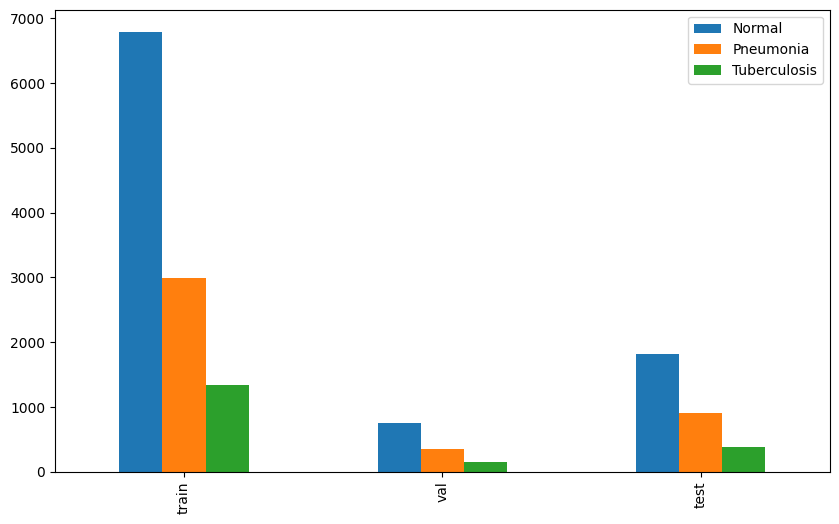

In [77]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

data= { "Normal":{
    'train': len(os.listdir('splitted_dataset/train/normal')),
    'val': len(os.listdir('splitted_dataset/val/normal')),
    'test': len(os.listdir('splitted_dataset/test/normal'))},
    "Pneumonia":{
    'train': len(os.listdir('splitted_dataset/train/pneumonia')),
    'val': len(os.listdir('splitted_dataset/val/pneumonia')),
    'test': len(os.listdir('splitted_dataset/test/pneumonia'))},
    "Tuberculosis":{
    'train': len(os.listdir('splitted_dataset/train/tubercolosis')),
    'val': len(os.listdir('splitted_dataset/val/tubercolosis')),
    'test': len(os.listdir('splitted_dataset/test/tubercolosis'))}}

data=pd.DataFrame(data)
data.plot(kind='bar', figsize=(10, 6))

# Test set merged
Generate a unified test set to have a single folder containing all the test images.

In [87]:
import os
list_test = os.listdir('splitted_dataset/test/normal') + os.listdir('splitted_dataset/test/tubercolosis')+os.listdir('splitted_dataset/test/pneumonia')
print(len(list_test))
print(list_test)

3095
['P00007_1.png', 'P00007_2.png', 'P00026_1.png', 'P00026_2.png', 'P00030_1.png', 'P00030_2.png', 'P00039_1.png', 'P00053_1.png', 'P00053_2.png', 'P00060_1.png', 'P00074_1.png', 'P00085_1.png', 'P00097_1.jpeg', 'P00097_2.jpeg', 'P00103_1.png', 'P00136_1.png', 'P00137_1.png', 'P00144_1.png', 'P00144_2.png', 'P00160_1.jpeg', 'P00160_2.jpeg', 'P00196_1.png', 'P00196_2.png', 'P00199_1.jpeg', 'P00203_1.png', 'P00203_2.png', 'P00220_1.png', 'P00220_2.png', 'P00222_1.png', 'P00230_1.png', 'P00232_1.jpeg', 'P00232_2.jpeg', 'P00233_1.png', 'P00255_1.png', 'P00255_2.png', 'P00259_1.png', 'P00277_1.png', 'P00280_1.png', 'P00292_1.png', 'P00292_2.png', 'P00300_1.png', 'P00300_2.png', 'P00336_1.png', 'P00367_1.jpeg', 'P00374_1.png', 'P00376_1.png', 'P00383_1.png', 'P00399_1.png', 'P00410_1.png', 'P00447_1.png', 'P00453_1.png', 'P00453_2.png', 'P00454_1.png', 'P00454_2.png', 'P00456_1.png', 'P00457_1.png', 'P00464_1.jpeg', 'P00490_1.png', 'P00498_1.jpeg', 'P00499_1.png', 'P00499_2.png', 'P00510_

In [88]:
import shutil

source_dir = os.path.join("splitted_dataset", "test")
dest_dir = os.path.join("test_merged", "all")

make_dir(dest_dir)

print("########## Creating Set Folder ##########")
print("From ", source_dir, "to ", dest_dir)

count = 0
for fold in os.listdir(source_dir): 
  for file_name in os.listdir(os.path.join(source_dir, fold)):
    src = os.path.join(source_dir, fold, file_name)
    dst = os.path.join(dest_dir, file_name)
    shutil.copyfile(src, dst)
    count= count+1

print(count," items moved")

Directory created:  test_merged\all
########## Creating Set Folder ##########
From  splitted_dataset\test to  test_merged\all
3095  items moved


In [93]:
import csv
import pandas as pd

csv_df = pd.read_csv('labels_train.csv')
print(csv_df.shape)
csv_df.head()

(15470, 2)


,file,label
0,P00001_1.png,N
1,P00001_2.png,N
2,P00002_1.png,N
3,P00003_1.png,N
4,P00004_1.jpeg,N


In [94]:
test_csv = csv_df
list_test = os.listdir(dest_dir)

for index, row in test_csv.iterrows():
  if row["file"] not in list_test: test_csv.drop(index, inplace=True)

test_csv = test_csv.reset_index().drop(columns=["index"])

print(test_csv.shape)
test_csv

(3095, 2)


,file,label
0,P00007_1.png,N
1,P00007_2.png,N
2,P00011_1.jpeg,P
3,P00011_2.jpeg,P
4,P00024_1.jpeg,P
...,...,...
3090,P16092_1.jpeg,P
3091,P16096_1.jpeg,P
3092,P16103_1.png,N
3093,P16107_1.jpeg,P


In [95]:
test_csv.to_csv('test_merged/Test_list.csv')

In [97]:
os.listdir("test_merged")

['all', 'Test_list.csv']